# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [96]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

# n_traits = 10
# active_traits = 10


In [97]:
generate_student_name()

'BIHOM DEWI '

In [98]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [99]:
active_traits = 100
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.075196407410573
th 7.130072753253939 10.205269160664512
null-task passrate 0.7310585786300049
all-null passrate 2.4843785557240134e-14
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
limits 0.9978283039153395 0.9978283039153395
[[1 2 3]
 [7 8 9]]
(2, 3)


In [100]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [101]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
#         n_c =  numpy.random.choice(range(1,active_traits))
        n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.thetas[c] = random.uniform(min_a, max_a)  
            self.thetas[c] = uniform(min_a, max_a) #(7,22)


In [102]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [103]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [104]:
# def create_encounter_keys(volume, n_active):
#     prs = [ uniform(0.01,0.99) for _ in range(volume) ]
# #     print(caius)
#     compons = [ randint(1,n_active) for _ in range(volume) ]
# #     print(compons)
#     comp_ps = [ p**(1/n) for p,n in zip(prs,compons)]
# #     comp_ps = [ p for p,n in zip(prs,compons)]
# #     print(comp_ps)
#     spreads = [ -math.log((1.0/pr)-1.0) for pr in comp_ps ]
    
#     hard_comp_del = min(spreads)
#     easy_comp_del = max(spreads)
#     offset = (easy_comp_del - hard_comp_del)/2
#     baseline = 1
#     beta_min = baseline+0
#     # beta_max = baseline+round(offset,1)
#     # theta_min = baseline+round(easy_comp_del - offset,1)
#     # theta_max = baseline+round(easy_comp_del,1)
#     beta_max = baseline+(offset)
#     theta_min = baseline+(easy_comp_del - offset)
#     theta_max = baseline+(easy_comp_del)

#     print(beta_min, beta_max)
#     print(theta_min, theta_max)

#     ths=[]
#     bs=[]
#     lowest = math.inf
#     for s in spreads:
#         choyce = random.choice(["th","b"])
#         if choyce=="th":
#             th = random.uniform(theta_min, theta_max)
#             b = th-s
#             lowest = b if b < lowest else lowest
#         else:
#             b = random.uniform(beta_min, beta_max)
#             th = b-s
#             lowest = th if th < lowest else lowest
#         ths.append(th)
#         bs.append(b)
    
#     ths = [th-lowest for th in ths]
#     bs = [b-lowest for b in bs]
        
#     plt.hist(ths)
#     plt.show()
#     plt.hist(bs)
#     plt.show()
# #     print(spreads)
#     plt.hist(spreads, bins=25)
#     plt.show()
#     return prs

# create_encounter_keys(1000,5)


In [105]:
# def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
#     from sklearn.datasets.samples_generator import make_blobs
#     from sklearn.preprocessing import MinMaxScaler
    
#     #beta_min,beta_max
#     sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
#     X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
# #     baseline = numpy.min(X)
# #     X = X - baseline
#     X = sc.fit_transform(X)

#     df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
#     colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
#     fig, ax = plt.subplots()
#     grouped = df.groupby('label')
#     for key, group in grouped:
#         group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
#     plt.show()
    
#     qns = []
#     for qix, (blob, y) in enumerate(zip(X,y)):
#         qn = Question(qix, 0,0, nt=nt, nnw=nnw)
#         qn.betas = blob
#         qn.group = y
#         qns.append(qn)
        
#     mags = []
#     no_comps = []
#     for q in qns:
#         comps = [c for c in q.betas if c>0]
#         mag = sqrt(sum([ pow(b, 2) for b in comps ]))
#         print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
#         mags.append(mag)
#         no_comps.append(len(comps))
        
#     plt.hist(mags)
#     plt.show()
#     plt.hist(no_comps)
#     plt.show()
    
#     qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
#     return qns, qn_table

In [106]:
def create_qs(n_qs, beta_min, beta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

In [107]:
def create_students(n_students, theta_min, theta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list, psi_table
    

In [108]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

#     q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
#     s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

#     q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
#     q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])
    
#     topped_up = Lambda(lambda ps_q:  K.clip(ps_q[0]+(1.0-ps_q[1]), 0,1))([Prs_holed, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [109]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [110]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [111]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    print(attempts[0:100])
    shuffle(attempts)

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    split = len_all//10
    
    vqices = qices[0:split] #array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
    vpsices = psices[0:split] #array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
    vpfs = pfs[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    qz = qices[split:]
    sz = psices[split:]
    pfz = pfs[split:]
    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))

            psi_wgts = s_table.get_weights()[0]
#             psi_qmx_wgts = s_qmx_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
#                 masque = psi_qmx_wgts[s.id]
                spred = psi_wgts[s.id] #* masque
                sreal = s.thetas
                err = numpy.abs(numpy.sort(spred) - numpy.sort(sreal))
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
#             qn_qmx_wgts = q_qmx_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
#                 masque = qn_qmx_wgts[q.id]
#                 print("masque =", masque)
                qpred = numpy.sort(qn_wgts[q.id])
#                 print("qpred =", qpred)
                qreal = numpy.sort(q.betas)
#                 print("qreal =", qreal)
                err = numpy.abs(qpred - qreal)
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            av_rmse = loss
            print("av RMSE=",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [112]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

Q:0, difficulty=511.97 across 100 components
Q:1, difficulty=541.82 across 100 components
Q:2, difficulty=573.66 across 100 components
Q:3, difficulty=525.98 across 100 components
Q:4, difficulty=586.38 across 100 components
Q:5, difficulty=582.88 across 100 components
Q:6, difficulty=580.47 across 100 components
Q:7, difficulty=584.34 across 100 components
Q:8, difficulty=564.21 across 100 components
Q:9, difficulty=556.67 across 100 components
Q:10, difficulty=579.57 across 100 components
Q:11, difficulty=578.19 across 100 components
Q:12, difficulty=572.20 across 100 components
Q:13, difficulty=554.77 across 100 components
Q:14, difficulty=586.64 across 100 components
Q:15, difficulty=546.35 across 100 components
Q:16, difficulty=545.28 across 100 components
Q:17, difficulty=563.63 across 100 components
Q:18, difficulty=532.66 across 100 components
Q:19, difficulty=527.27 across 100 components
Q:20, difficulty=595.68 across 100 components
Q:21, difficulty=547.17 across 100 component

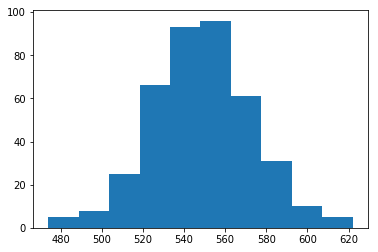

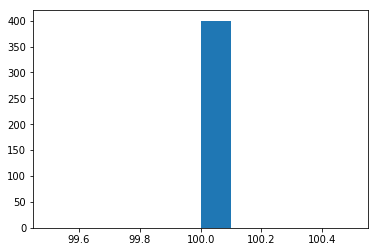

qid 0 [38.528937137535614, 86.34806413915608, 42.18265210778129, 62.259881634304435, 19.03461961129662, 76.7605600867745, 54.364105620372015, 20.10228956848031, 21.863855269440865, 38.10091523428378, 59.536584777034776, 30.392861698168627, 46.98433149185601, 34.183076298719165, 62.186083598073544, 4.031020018895955, 18.268901945015717, 41.43101970987377, 42.66824716999111, 76.32185534760717, 26.97312301241166, 4.693099016322617, 41.555764817321915, 68.08239220122181, 60.872616206040775, 55.30002664226824, 88.03572552699778, 37.421399581113356, 62.54442247506972, 24.45315397199258, 80.48068145548069, 19.442631487923588, 43.663254945471955, 7.850179572903535, 50.790080372710065, 8.174587464214987, 27.783579449470402, 77.46639095303033, 51.10205263787459, 11.704928579733568, 5.849335839707069, 33.87334378489356, 31.072361365074276, 71.61287317493026, 22.494783416716867, 41.62969086754011, 33.57043136934998, 40.85973938105025, 58.51666646816276, 86.63250133598777, 20.378040197010566, 8.506

qid 340 [13.221149604093673, 53.629389903219796, 7.240945025876597, 53.786679902443204, 4.439592218468544, 84.84368654137961, 27.156825571872773, 31.53498674247679, 2.954225244797647, 68.02414666365121, 27.23651380614962, 17.237150760931875, 25.51805202774894, 75.2698148884158, 94.88044225353784, 31.00305164349108, 66.19636604125199, 22.477663185289934, 62.61227554667355, 44.0403961708236, 25.69082924109297, 72.49921347883996, 86.897276401794, 77.08223983570375, 50.86022731822893, 73.98483504169883, 65.84395269377002, 33.8000268049468, 84.10703168833602, 37.86586776693824, 83.75725170827111, 51.99854845032523, 91.85193985086157, 85.01637256911137, 15.600397661980846, 16.08014023724558, 44.01834105758863, 17.514062711968958, 67.96642634143633, 60.02168740099741, 39.96504869236418, 76.51495863593254, 20.402387469794093, 23.145209733711567, 21.378692705875416, 58.158709206346536, 69.78109791490033, 76.71290790463208, 57.3081307850322, 17.460201647194463, 64.27219257680892, 16.299040114064

HOMI PAK , skill=1660.86 across 100 comps
BUVOS TECHYJ , skill=1691.26 across 100 comps
CIV GATHE , skill=1707.85 across 100 comps
KOM CHUF , skill=1638.17 across 100 comps
POR FYC , skill=1675.39 across 100 comps
BUCHO FYBOG , skill=1637.71 across 100 comps
GYD SOPHUC , skill=1736.41 across 100 comps
WAM MAKOP , skill=1670.37 across 100 comps
VIWU CAVOV , skill=1588.02 across 100 comps
WAMA NEKAM , skill=1663.18 across 100 comps
THOCU JUFAPH , skill=1666.68 across 100 comps
PUFAV FUTHE , skill=1694.40 across 100 comps
MOSY MED , skill=1716.19 across 100 comps
BOTHOCH DOTHET , skill=1652.47 across 100 comps
PHOGY WECA , skill=1707.31 across 100 comps
HYK SUPAPH , skill=1658.04 across 100 comps
WYKYR GODEPH , skill=1702.14 across 100 comps
NAL MAHI , skill=1657.16 across 100 comps
DEHEW WUSO , skill=1616.19 across 100 comps
FYVU WAT , skill=1657.81 across 100 comps
YESY DEYU , skill=1697.87 across 100 comps
YEFY FYFITH , skill=1641.61 across 100 comps
BAPH WELYW , skill=1673.41 across 1

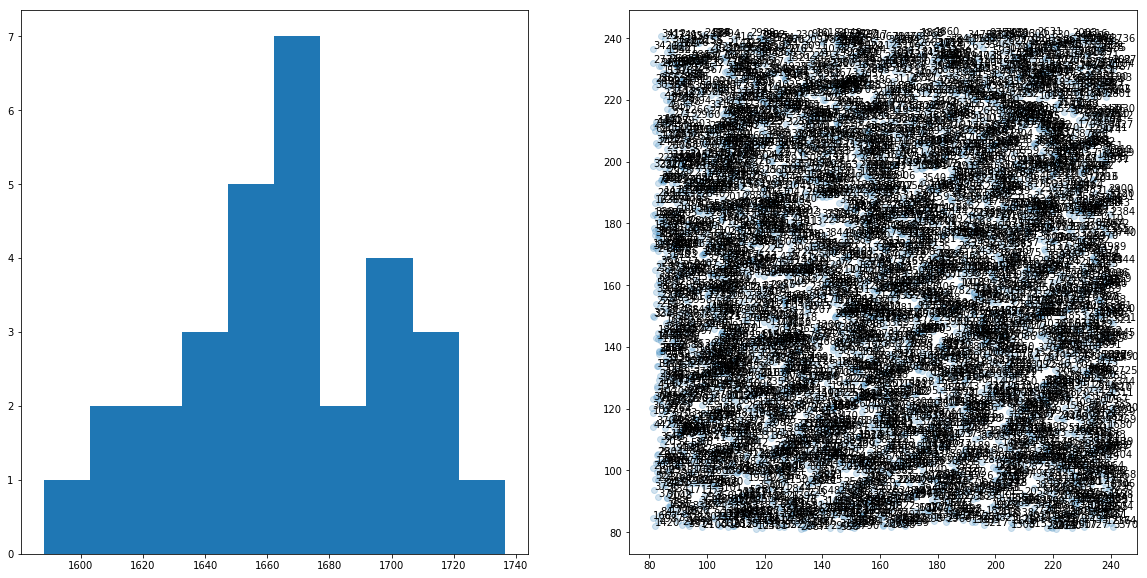

----0

>>Passed 831297/1600000
<__main__.BigTable object at 0x000000893FA7B748> <__main__.BigTable object at 0x000000893D5CC898> Tensor("psi_select_28:0", shape=(?, 1), dtype=int32) Tensor("q_select_28:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (400, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (400, 100)
'rows' shape, (?, 100)
kk (4000, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (4000, 100)
'rows' shape, (?, 100)
dif (?, 100)
Pr (?, 1)
[ 195.69332886  102.08764648  183.41397095   92.88983917  133.33531189
  152.01585388   88.62294006   92.13915253  178.16049194  130.38336182
  136.28361511  143.65113831  148.06932068  234.74415588  191.16918945
  157.31738281  206.07539368  230.92539978  101.83587646  143.848526
  150.56015015   99.69055176   94.78071594  230.63537598  156.46966553
  199.17485046  170.00280762  218.05612183  209.65145874  197.72740173
  126.92918396  152.46394348  133.929245    217.21875     124.08667755
  139.31100464   85.

  209.58795166  208.32920837  117.7616806    85.86906433   95.96414185]
[ 173.04219055  234.91984558  106.35919189  117.80716705  155.78295898
  165.88201904  163.33451843  184.26344299  157.02238464  123.61735535
  210.38771057  115.15163422  140.81141663  152.13748169  177.10255432
  127.96960449  110.62730408  128.72535706  199.93095398  141.02713013
  202.17425537  190.94845581  164.78106689  205.94325256  132.39349365
   85.46950531  131.4094696    94.46514893  137.37179565  100.58409119
  172.91087341  161.31230164  145.79431152  198.32174683  152.17022705
  128.72401428  109.13507843  240.22181702   85.63412476  148.80795288
  226.7219696   237.11079407  229.75753784  123.43649292  145.90057373
  138.99517822   91.83584595  113.97923279  167.11943054  106.31768036
  159.27372742  133.32554626  143.80793762  171.12077332  227.30747986
  215.78192139  239.67950439  109.74939728  207.54473877  238.1434021
  144.84020996   99.90422058  135.16291809  169.15835571  212.00502014
   96.

[ 176.45010376  225.29705811  167.54612732  240.540802    205.86706543
  220.46099854  100.71603394  222.67185974  119.3236084   237.58381653
  182.56532288   91.25593567  219.09112549  186.44567871  223.25216675
  130.45237732  131.32991028  232.4810791   179.00389099  201.07151794
  108.4995575   184.43476868  208.71980286  203.42715454  159.25726318
  205.04629517  103.14466095  165.371521    237.73052979   84.40549469
  234.62489319  221.21809387  216.67481995  205.49246216  161.67903137
  228.11248779  193.70500183  112.01033783  103.56693268  202.79090881
  108.01100159   88.85881042   81.2853241    89.75734711  191.35813904
  186.55505371  152.73428345  174.00514221   95.01303864  116.30638123
   88.59328461   98.58029175  202.23728943   95.3669281   108.91454315
  142.78616333  131.33599854  109.99583435  106.98620605  150.30377197
  148.12635803  100.58608246  162.39807129  114.84490967  210.30625916
  221.88653564  220.77622986   96.78901672  150.14717102  239.84934998
  161.

[ 211.55690002  146.7782135   116.81678009   81.5164566   142.25244141
  180.97309875  181.76434326  222.44664001  189.08905029  210.3318634
  113.10771179  112.12755585  236.82478333  222.95037842  123.31430054
  189.84526062  206.70327759  161.21772766  144.05067444  167.22732544
  192.13180542  176.94659424  219.31987     138.64620972  219.68238831
   84.63173676  214.36668396  203.62477112  167.6315918   116.6269455
  177.89707947  204.79220581  182.96543884   98.12725067  155.70231628
  166.81105042  181.35858154  123.46544647  199.03411865  177.01074219
  194.7668457   170.68457031  120.32436371  239.19190979  180.97106934
  167.33863831   88.44379425  189.62214661  169.23846436  109.25364685
  130.56793213  236.12841797  148.3946228   237.5667572   215.81069946
   88.15500641  109.65556335  153.50714111  110.52085114  226.6124115
   98.98052979  146.27479553  156.8894043   221.36872864  146.88844299
   99.09286499  173.53137207  183.03561401  179.57669067  173.17984009
  134.003

[ 240.84152222  154.48551941  125.4500351    86.28367615  142.92088318
  177.63798523  226.43348694  235.24111938  238.68186951   87.39245605
  230.35676575  153.98141479   90.59797668  228.29356384  208.56381226
  140.34761047   90.00504303   88.77311707  127.32466125  227.29707336
   96.63027954  167.58627319  165.99436951  240.70396423  219.05680847
  109.57607269  154.14929199  149.54943848  129.07522583  210.52426147
  138.62698364  165.18244934  201.49336243   84.43943024  192.96142578
  221.36526489   89.17365265  180.47601318   90.658638    193.77085876
   97.64418793  200.47323608  191.56842041  233.77590942  196.35302734
  175.24275208  115.27649689  200.81489563   91.1802597   162.9196167
  113.27959442  207.15383911   85.37281036  222.28153992  237.65513611
  167.98629761  183.16111755  182.82553101   91.27159882  129.68351746
  139.28384399  164.32017517  155.67980957  234.12556458  147.90631104
  178.19165039  179.0664978   111.36799622  209.79867554   92.39506531
   93.8

[ 117.25041199  196.48220825  233.89215088  118.37484741  203.7943573
  177.64593506  197.17324829  102.76800537  195.65281677  198.1096344
  126.3640213   214.79566956   81.51999664  227.16877747  139.51901245
  237.69715881  235.93943787  184.5010376   233.66729736  223.8553772
  124.19037628  157.13423157  125.61658478  177.10050964  177.60479736
  225.18049622  167.74913025   98.3293457   134.71165466  184.77001953
  160.59162903  140.05659485  134.14318848  114.53610992  126.44924927
  153.38374329  101.68206787  175.72177124  189.22866821  175.81715393
  119.27091217   99.3799057   135.72187805   97.82924652  227.26161194
  168.79411316  208.40229797  159.7543335   139.67285156  159.04170227
  165.33647156  177.92855835  166.92356873  118.97058868  192.40400696
  184.52372742  103.28413391  203.33180237  149.23770142  166.11450195
  188.10600281  205.20567322  162.2036438   185.11112976  232.71090698
  142.63685608  129.85223389  215.9176178   190.14761353  177.07757568
  200.745

[ 163.8706665    83.97121429  160.46347046  116.20809174  128.29292297
   84.78955841  125.26254272  105.76380157  102.09933472  159.00325012
  224.97303772  196.20272827  215.51507568  173.32496643  220.83546448
  192.05197144   83.06124878  202.2250061   164.3266449   141.73139954
  128.62260437   97.44120026  115.73078156  219.84196472  110.40679169
  130.35317993  236.51963806  208.06329346  110.92120361  154.03889465
  150.86387634  204.49977112  198.35681152  121.15153503  108.44484711
   89.05056763  158.1620636   140.77037048   99.13758087  192.0017395
  192.51777649  147.05741882  177.06066895  172.74452209  215.1390686
  151.24337769  171.21598816  150.78961182  222.50968933  215.50267029
  140.44500732  148.14083862   98.41853333  216.13943481  216.60440063
  209.17489624  103.67389679  165.60220337  187.38513184  224.80271912
   90.83000946  120.56462097   92.40122986  189.7334137   111.91795349
  220.62910461  212.48959351  145.87438965  153.78488159  126.09552002
   95.09

  238.69104004  119.94147491   90.15293121  179.70904541   88.11542511]
[ 158.40821838  154.4773407   165.42338562  195.93438721  206.36924744
   94.99756622  132.71430969  177.93115234  160.01239014  158.98226929
   82.61457062  170.5254364   207.10813904  197.14265442  236.5249939
  190.08106995  163.52758789  157.50184631  183.71237183  237.57089233
  101.70970154  239.86216736   92.74742126  171.22697449  222.81987
  229.526474    170.52366638  146.97984314  170.00804138  191.03746033
  220.39518738  218.57098389  235.58082581  191.10864258  226.22390747
  227.1275177   174.41281128  132.32342529  206.39189148  102.46779633
  214.94160461  197.63995361   84.60011292  229.120224    194.06636047
  128.57080078   84.8214798   234.25213623  208.73625183   90.67107391
  121.09181213   81.51486206   87.0378418    91.69960785  211.62802124
  196.64143372  206.29678345  236.30244446  163.07571411  207.26841736
  209.37271118  128.90524292  191.29830933  189.34085083  240.09945679
  234.545

  101.53887177  111.79665375  183.66152954  157.16514587  235.76734924]
[ 184.49258423  169.44741821  131.03158569  189.9365387   154.92051697
  112.25878143  150.58610535  205.79284668  111.33159637  126.28697968
  223.87155151  233.22068787  161.78468323   90.18315887  105.91542053
  161.88978577  223.65306091  228.66738892  142.95195007  176.25854492
   94.09552765   99.22614288  102.59555817   99.58827972  148.93914795
  137.80819702  185.88186646  185.50956726  223.85220337  139.04042053
  134.79864502  224.71212769  141.40776062  235.94589233  200.22845459
  164.53346252   85.38949585  112.0140152    92.38763428  198.30789185
  106.73693848  185.51570129  151.16575623  122.38006592  144.51148987
  167.64247131  158.52284241  134.01118469   97.23497009  109.19628143
   84.79994202  142.72210693  176.70657349  220.51405334  240.50421143
  123.09945679  179.71191406  158.62809753  232.99278259  101.67770386
  219.54541016  177.56924438  121.66921997  173.12284851  166.52416992
  177

   98.68883514  223.94676208  170.75205994  195.99545288  171.30947876]
[ 121.90519714  198.74433899  178.83227539  154.07835388  170.50630188
  169.15797424  178.62107849  142.55787659  216.8056488   159.93333435
  227.12443542  189.80281067  214.08999634  105.57759857  177.81095886
  134.09339905  116.73348236  148.42582703  125.31244659  192.35658264
  173.48114014  218.75265503  229.94992065  125.82436371  207.58148193
  142.19155884   98.4031601   105.11554718  182.78511047  110.60272217
  132.16148376  165.61099243  176.88061523  177.95361328  238.89460754
  201.24502563  131.05517578  197.20751953  217.96740723  141.89030457
  170.03898621  143.94186401  108.41833496  225.88212585  211.74209595
  136.44134521  161.56072998  146.10290527  131.74223328   97.69004059
  186.78520203  226.66505432  231.38638306  116.58005524  148.91369629
  221.2118988   176.17076111   96.07567596  172.4491272   106.08805847
  197.86517334  156.3112793    90.06562042  106.16703796  232.25141907
  153

[ 159.64079285   97.68759918  191.48226929  201.61553955   88.90622711
   91.55544281  138.65800476  194.75756836   87.70935822  134.90629578
  121.35367584  180.76907349  224.95204163  102.02748108  149.34918213
  173.91471863  203.99049377  215.24107361   93.39949036  213.63288879
  157.35169983  107.33409882  213.3263092   232.21798706  189.11984253
   92.2069931   123.81620026  167.8759613   211.27902222  213.57617188
  216.13291931  157.18598938  239.97219849  189.6803894    85.84265137
  224.15408325  143.60830688  105.96476746  151.87612915  137.16932678
  198.33235168  229.08338928   94.64902496  169.46443176  201.42333984
  146.28617859  208.30490112  135.2840271   172.02043152  217.83615112
   83.70570374  113.31349182  103.90897369  175.37792969   96.18202972
  119.33396149  133.98199463  219.60890198  193.14160156  227.16598511
   92.9605484   225.62023926  179.32270813  236.69367981  183.8449707
  159.71713257   95.56434631  146.10342407  146.34539795  201.16584778
  220.4

[  90.83906555  153.80535889  163.13494873  177.36740112  239.47473145
  155.40670776  226.19818115  215.73474121  119.86532593  179.8407135
  142.3079071   205.53643799  101.3408432   177.51490784  151.89631653
   87.1255722   219.32769775  180.30281067  124.93808746  240.64985657
  157.9414978   221.16477966  120.62229156  168.28199768  199.85223389
  140.17477417   95.00718689  232.25782776  209.10575867  142.31794739
   84.51753235  133.91036987  115.93515778  233.75811768  220.63522339
  121.33611298  151.51377869  104.68800354   95.46383667  144.0851593
  100.69128418  133.9103241   138.30020142  203.04766846  188.05941772
  130.96095276  131.46937561   93.83560181  171.89515686  137.02883911
  136.53694153   81.12033081  129.21841431  149.12269592   89.80278778
  229.50053406  200.03363037  141.26431274  226.16401672  146.66120911
  124.0880127   228.50683594  213.72413635   93.04367828  200.02674866
  127.93269348  164.17973328  182.37088013   96.74931335  112.46938324
  199.95

  145.62924194  168.89668274  112.33488464  125.10483551  210.42044067]
[ 219.83003235   88.88807678  189.29225159  222.00248718  165.74287415
  117.24001312  112.94801331  204.81254578  129.08049011  230.38336182
  165.21568298  197.61680603  102.05458069  130.45880127  176.36157227
  110.7053299   174.96463013  157.52726746  144.53012085  196.58277893
  204.56800842  223.29333496  115.38013458   86.84840393  236.19781494
  172.8629303   158.94967651  121.65658569  123.00444031   87.26793671
  111.11226654  163.77648926  204.48109436  140.91947937  194.68655396
  149.91694641  218.25296021  179.10743713  104.61405945  122.12236023
  168.08111572   96.15232086  209.33869934   95.44642639  121.48181915
  150.23034668  193.01805115   89.74514771  119.97788239  223.52050781
  214.28205872  182.92379761  168.75428772  191.4458313   235.73719788
  174.32382202  220.49200439  200.28378296  217.29753113  227.04562378
  216.22062683   81.5647049    83.40920258  152.12818909  185.71881104
   88

[ 174.54530334  114.73054504  215.1015625   170.96083069  139.54244995
  213.28749084  176.71507263  194.64479065  233.31674194  164.12792969
  106.54869843  237.38006592  236.93586731  165.92817688  226.87393188
   84.83065796  145.8679657   122.31375885  164.00094604   99.07238007
  191.83442688   91.49026489  126.24996948  121.3967514   190.94102478
  171.43161011  188.94781494  132.09396362  105.84374237  187.89660645
  146.77148438   82.06439972  139.68971252   92.95864105   97.66699982
  181.40921021  172.70941162  141.42306519  124.26148987  200.99417114
  161.68600464  150.10223389  217.86244202  212.68695068  163.57550049
  237.77458191  211.3888855   157.84786987  115.12970734   86.02414703
  175.14703369  119.90625     126.35050201  228.70219421  202.22009277
  113.69896698  181.15957642   89.43071747  152.57696533  200.01127625
  185.30691528  209.66981506   81.6572113   209.71151733  194.05464172
  174.3961792   106.44107056  100.01693726  109.93418884  233.36555481
  104.

[ 195.44442749  201.31974792  127.75009155  162.51261902  148.56491089
  196.67018127  217.96586609  114.52908325  181.01205444  239.12863159
  150.83847046   90.19573975  104.36005402  134.59466553  169.09945679
  153.14331055  170.32147217  181.14845276  140.26832581  184.25222778
   97.36346436  139.8293457   147.39816284  229.99987793  140.0541687
  237.03340149  236.93817139  143.6867218   151.60379028   95.6886673
  103.80111694   81.06121063  206.01347351  183.03469849  101.20566559
  180.39295959  200.15934753  124.01074982  145.97340393   85.802948
  165.19035339  190.26626587  187.79275513  228.10812378   86.49567413
  174.53713989  144.63154602  214.50614929   94.59285736  160.90214539
  139.58830261  236.96385193  209.50531006  187.35046387  213.87690735
  179.18855286  151.33244324  231.82411194  203.06428528  158.66009521
  154.53915405  172.82347107  216.95658875  114.994133    140.04566956
  106.27703094  221.53640747  236.70791626  164.92727661  147.77946472
  135.9427

[ 228.12289429  113.36746216  135.6998291   187.42103577  240.91989136
  233.17347717  198.77326965  204.50621033  191.87361145  181.27514648
  173.12284851  104.00576019  142.82775879  195.69644165  214.74180603
  150.73544312  175.43450928  102.05580902  122.54962921  151.17416382
  168.18504333   93.14588928  214.64169312  181.19265747  141.87086487
  150.54896545  219.51699829  124.04320526   95.26985931  203.79522705
  223.88439941   93.23109436  123.20117188  190.6076355   116.87036133
  129.61437988  197.74919128  151.07646179   90.43741608  223.89830017
  215.02857971  196.14933777  149.42138672  212.46844482  129.57499695
  174.60801697  184.91955566  229.71253967  144.16618347  156.30651855
  163.01443481  213.77801514  133.94595337  237.93518066   91.82428741
  237.7026062   179.81880188   89.71208954  106.00318146   81.913414
  143.24488831  216.46798706  225.65867615  170.6728363   190.72123718
   82.57039642  129.63748169  201.24928284  128.06243896  204.20822144
  211.98

  126.84899902  144.72880554  145.70152283  126.99385071  218.84765625]
[ 194.13276672  206.28141785  225.37139893  107.75984955  157.63052368
  146.00811768  129.47351074  148.23918152   84.38564301  187.06977844
  167.3717804   240.83157349  178.09896851  168.55526733  164.68060303
  169.91081238  239.89930725  209.06654358   95.3536377   139.28466797
  170.99205017  222.09387207   84.31567383  210.12272644  166.98924255
  215.60404968   89.37945557  207.50608826  182.06756592  134.51982117
  238.52078247  200.64894104  210.88208008  232.75906372  191.03196716
  196.68885803  126.18105316  146.33016968  157.96856689  161.52745056
  229.49093628  209.0617981   219.15344238  227.25268555  140.06414795
  216.98841858  213.67434692  142.12434387  152.77339172  112.02346802
   83.85443115  144.48406982  219.76309204  156.50622559  135.85694885
  221.74845886  161.90005493  203.60150146  129.3553009   125.97638702
   92.86664581  102.8490448   230.171875    240.00840759  230.2598114
  159.

[ 167.46246338  188.14424133  221.59355164  165.27812195  180.38983154
  151.39881897  155.98461914  107.64995575  206.19871521  216.50732422
  102.5302124   167.48652649   81.03206635  237.39215088  217.89328003
   98.82897949  209.54827881  236.82795715  192.87626648  149.6958313
  180.00068665  136.61279297  238.47351074  185.2762146   157.82168579
   88.62265015  180.35786438  181.28074646  209.14459229  177.30238342
  112.87493134  112.87949371  191.29458618  121.18717194  233.0728302
  153.21374512  235.91215515  162.02546692  170.25476074  219.38168335
  227.01527405  187.81892395  199.19430542  128.91459656  200.5380249
  130.86529541  100.70465088  175.29333496  113.2056427   175.25474548
  114.52039337  233.09823608   84.30247498  182.09823608  234.50558472
  162.26498413  162.28039551   81.10895538  124.82815552  204.63777161
   92.64769745  201.49940491   81.48118591   96.59794617  205.05386353
   85.31330872  131.13139343  100.94100189  210.85787964  178.00897217
  109.156

[ 158.22267151  212.60324097  148.69696045  195.48921204   86.36348724
  136.30662537  113.63795471  174.06881714  174.55541992  170.04946899
  148.21975708   94.4637146   142.10719299  192.75114441  119.85626221
  172.92553711  167.22438049  212.64974976  211.04211426  238.40184021
  237.11289978  136.9236908   201.57154846  112.73244476  209.18325806
  237.26393127  212.5322113   237.38710022  160.92053223  237.01106262
  231.03636169  183.45657349  196.72886658  180.59095764  193.33413696
  125.72834015  207.60600281  172.256073    220.39341736  165.62995911
  126.5898819   111.68430328   95.02083588  132.43695068  141.8704834
  148.02738953  123.97285461  198.62983704  156.5488739   112.70807648
  202.75512695  105.01630402  168.17605591  198.34233093  226.98931885
  169.04191589  192.54232788  181.63014221   98.04125214  113.21517181
  204.73956299  166.66825867  143.39234924  217.35691833   91.08533478
  118.35586548  139.94923401  173.82424927  187.80914307  169.97302246
  143.1

[ 141.02900696  211.10025024  172.6282196   219.81063843  140.6374054
  114.38404083  136.63853455  225.04296875  175.02729797  184.69226074
  170.74180603  169.64682007  221.93493652  143.54165649  192.30581665
  217.15319824  117.89647675  157.35527039  117.94568634  211.79742432
  125.80077362  195.99293518   81.33750916  128.58631897  164.3991394
  104.93545532   83.77568817  144.168396    158.89463806  172.63468933
  185.17425537  109.45264435  107.74634552  186.60539246  200.95066833
  100.08674622  165.13648987  156.63954163  199.97575378  116.97837067
  220.11210632  229.24603271  106.87771606  125.50413513  104.89319611
  226.852005    166.29582214  103.16145325  175.83474731  140.30857849
  200.48542786  114.40787506  231.10456848  201.71031189  100.09951019
  228.06764221  200.74383545  168.81636047  190.8551178   161.87831116
  154.40872192  106.96884918  218.50262451  199.45690918  202.38616943
  114.76407623   96.70677185  124.7674942   131.864151    163.82917786
  205.74

[ 174.46482849  157.40338135  149.95350647  108.013237    202.39181519
  161.03663635  181.24023438  142.13224792  159.42764282  204.37055969
  100.63015747   81.23374176   88.49745941  143.54959106  208.7848053
  138.95043945  213.73997498  125.70889282  209.74853516  125.7358017
  191.50216675   81.53992462  201.95243835  174.11158752  202.28927612
  120.28148651  169.02880859  145.67800903  110.42403412  177.00260925
  160.74168396  236.6658783   234.83425903   97.57762146  217.50579834
  194.50334167  195.19647217   92.97755432  205.51219177  143.80647278
  117.98097992  103.18066406  101.78211975  112.24382782  115.75236511
  154.72477722  165.34811401  105.4553833   116.22962952  148.81752014
   99.21576691  183.67036438  101.74225616   83.43334961  191.72181702
  167.2625885   151.80862427  211.24386597  116.78948975  127.17418671
  148.39891052  179.06256104  128.43563843  145.15985107  155.11723328
  205.70144653  212.17044067  178.72543335  143.54066467  179.23118591
  215.41

[  99.84361267  153.41612244  153.68208313  233.24168396  179.52053833
  219.56352234  207.61218262  236.61997986   93.81092834   88.35868835
  154.91305542  208.6194458   238.39527893   86.55601501  110.53579712
  238.22642517  146.890625    230.12770081  237.89007568  168.6446991
  217.93096924  231.33586121  217.63476562  240.05224609  230.24729919
  193.55001831  114.80886078  234.03646851   97.68367767   81.33337402
  205.00582886   90.12788391   98.68761444  112.40804291  139.40991211
  121.97809601  136.34603882  227.5410614   202.3368988   125.37443542
  203.63105774  129.45581055  182.86755371  233.28982544  161.87536621
  134.05226135  169.76531982  137.26000977  157.40652466  102.61130524
   82.07743073   84.54103851  103.07009125  215.31816101   90.8715744
  146.73083496  162.33532715  231.31541443   85.78676605  166.73027039
  142.87542725  235.97639465  227.94456482  132.1166687   133.35340881
  144.00605774  158.18118286  233.32775879  126.49942017  103.45210266
   93.04

[ 137.7699585   209.60758972  198.11019897  205.44880676  211.09712219
   91.89173126  230.29981995  240.75917053  183.817276    136.55004883
  106.91268158   98.79454041  113.66776276   94.77777863  205.30854797
  129.15684509  110.16732788   89.18152618  221.0866394   233.12860107
   82.47574615  163.58152771  118.41442108  176.90142822  206.6869812
  179.56745911  160.16574097  119.17139435  219.54792786  238.11174011
  198.11186218  157.14482117  219.8694458   132.62841797  143.80102539
  184.29510498  199.58982849  162.77426147  130.81459045  174.16824341
  163.67095947  153.88453674  164.59385681  101.70839691  233.5271759
  153.27087402  103.52841187  227.35652161  215.10180664  101.17178345
  109.41333008  135.68890381  143.13511658  161.98399353  159.17817688
  211.25375366  131.02047729  115.45717621  192.87495422  196.31666565
  237.83670044  111.96858978  194.06718445   85.46461487  234.33453369
  123.37815857  135.45198059  220.79214478  239.76403809  226.06469727
  124.71

  168.37203979  196.86000061  226.2689209   235.60598755  230.90071106]
[ 156.67210388  173.1558075   144.76528931  223.4284668   221.33326721
  133.84751892  103.64360046  147.76374817  138.31924438  167.94821167
  228.94499207  166.25149536  168.27334595  225.2098999   121.45883179
  117.09275818  137.14657593  183.11955261  185.49133301  115.94890594
  116.56186676  150.28829956  202.83996582  200.3952179   184.75343323
  113.96574402  197.88648987  186.86068726  114.87361908  152.98905945
  174.60057068  103.29955292  140.83834839  196.29748535  186.14186096
  226.64448547  140.90849304  231.31262207  108.48523712   91.05239868
  212.09446716  197.52302551  181.85858154  190.79396057   82.20387268
  138.65454102  180.11802673  211.13038635  142.35684204  238.21772766
  137.85319519  115.05099487  232.52284241   82.6157608   146.75700378
   83.36063385  238.75653076  169.83235168  193.23997498  120.44425201
  151.71641541  103.98027039  204.46159363  105.46041107  218.74072266
  173

   81.72620392  108.72751617  200.6890564   108.04843903  114.07232666]
[ 111.37167358  156.1010437   110.17584991  170.07041931  189.95753479
  238.69615173  237.71533203  209.61228943  131.28645325  212.30467224
   93.55512238   87.93558502  223.00668335  152.81976318  239.87393188
  141.12406921  190.40480042  136.00402832  148.40324402  233.94984436
   85.78801727  104.82780457  233.36515808  210.56404114  226.31268311
  156.49760437  140.34100342  122.55560303  214.50567627  232.30326843
  145.49391174  196.44602966  147.97303772  176.71955872  100.63627625
  173.11199951  183.49899292  191.29307556  106.5059433    99.74092102
  203.59848022  224.08694458  162.65930176  131.45217896  208.34146118
  231.67585754  166.65945435   86.58816528  108.00920868  126.95622253
  166.42559814  118.87120056  240.93252563  236.12834167  145.30776978
   95.49980927   87.95539093  202.56607056   99.91955566  207.20126343
  148.66120911  105.99823761  223.94618225  235.53108215  120.40924835
  132

[ 223.52249146  130.5464325   194.53594971  234.70965576  104.98607635
  133.74911499  178.67788696  121.17053223  197.67930603   91.73763275
   90.44067383  156.13951111  238.41352844  182.45935059  202.68421936
  153.58729553  205.36805725  215.35723877  123.33376312  218.06520081
  134.1519928    85.12897491  163.97450256  184.19944763  121.54608154
  208.89517212  134.78279114  215.05149841  123.81118011  182.40499878
  219.82495117  182.52406311   81.61149597  117.80128479  118.52328491
  196.97140503  112.09329987  103.87573242  147.15927124  235.63084412
  152.98109436   96.20031738  156.97735596  145.71401978  225.17727661
  231.014328    225.44845581  198.64234924  125.75842285  153.16751099
  177.60209656  176.54489136  138.93688965  202.0070343   238.94389343
  174.12312317  196.03631592  144.2665863   126.56726837  239.39775085
  102.49845123  195.20545959  154.17631531  222.61407471  191.10188293
  104.28176117  193.50466919  223.57176208  190.4914093   219.34915161
  179.

  160.22401428  147.02928162  194.84231567  173.96969604  141.31474304]
[ 220.10322571   88.03326416   91.18964386  160.44015503  153.24041748
  108.01760101  237.17474365  186.19248962  163.97897339  142.82373047
  208.23954773  233.52954102  106.72903442  239.76164246  239.21643066
  156.71662903  171.02989197  110.52021027  195.79582214  157.12481689
  167.59593201  105.70719147  227.1476593   209.52571106  192.2265625
   87.10993195  182.33139038   93.68294525  154.61663818  157.72955322
   82.04738617   88.00566864   83.21051025  217.67710876  217.94650269
  174.97419739  192.83987427  120.34488678  176.63026428  230.04071045
  111.36121368  217.12232971   92.13822174  139.96582031  236.81788635
  238.31817627  178.14857483  234.68617249  111.08907318  181.5513916
  123.8868866    95.39844513  106.2201004   126.54919434   92.78977966
  139.28434753  106.86166382  158.4005127   144.48419189  174.2620697
  154.6418457   174.38143921  116.14712524  234.93161011   99.50418091
  225.92

  183.34558105  203.62789917  125.25740814  142.44468689   88.93169403]
[ 152.11192322  194.25642395  186.93551636  112.08864594  173.85137939
  214.31053162  131.03384399  220.83000183  132.24281311  181.80081177
  125.36709595  175.62039185  148.68101501   92.09254456  231.98068237
  226.56791687  201.17979431  190.43865967  189.47784424  164.11517334
  194.88072205   95.02559662  155.25306702  210.35327148  121.87182617
  233.92805481  104.2924881   197.47085571  230.02705383  166.48114014
  148.35328674   89.16744995  180.32725525  182.77252197  171.90222168
  210.5599823   134.28546143  107.10694885  212.79396057  181.31913757
  155.97846985  235.76512146  107.05240631  168.91864014  216.983078
  192.987854    181.3301239   102.00748444  148.63562012  214.11888123
  205.15419006  131.35702515  235.29652405  123.5568924   155.00592041
  213.91275024   90.33222961  225.04310608  218.17912292  224.3170929
  210.55125427   84.84501648  173.50382996  116.99864197  108.11920166
  126.88

  207.52667236  225.40693665  175.86645508  150.4196167   124.68294525]
[ 190.57513428  182.34205627  232.66041565  204.80503845  103.98638916
  201.92630005  182.76573181  188.93717957  214.44013977  173.26782227
  150.20320129  238.71411133  130.14382935  133.87477112  166.14653015
  186.51026917  152.00579834  115.36328125  206.17973328  216.94775391
  201.61219788  110.09494019  240.69999695   89.67210388  197.16920471
  210.98855591  177.18844604   98.72754669  175.13218689  108.50917816
  194.65666199  146.99024963  129.71990967  204.89755249  144.18716431
  112.06921387   89.47499084  157.03610229  178.3289032   202.64529419
  165.21403503  168.03286743  189.06987      84.28191376  221.85119629
  163.26553345  199.11026001   85.78999329  219.62249756  240.15408325
  141.30409241  168.67410278  145.59333801  153.03515625  165.37831116
  181.03053284  179.33551025  109.46212006  203.63446045  192.42007446
  161.91477966  210.95349121   94.51406097  176.49111938  102.86525726
   89

[ 187.93344116  201.42596436  240.51815796  156.85076904   83.88527679
   92.98390198  153.37081909  175.79263306  210.38777161  126.43561554
  192.61021423  148.38597107   89.78009796  188.06051636  108.33219147
  215.47154236  169.57484436  124.63866425  184.31340027  136.08889771
  107.29272461  217.97058105  206.78051758  150.76560974  215.48069763
  118.64524841  221.54545593  204.69418335  209.33802795  194.17677307
  196.27902222  157.71383667  199.27374268  185.0120697   190.8493042
  227.07981873  155.56930542  117.63954163  145.00485229  229.99893188
  223.47373962  171.45558167  119.09712982  131.91061401  117.48503113
  141.6686554   103.23215485   92.64030457  186.96591187  172.65402222
  133.04136658   84.74310303  236.55368042  179.76098633   94.07582092
  186.38911438  153.46652222  145.69975281  177.0227356   105.48766327
  118.28578186  217.73728943  225.63041687  114.03208923  237.79321289
  142.53135681  180.81939697  181.31193542  155.4672699   175.22280884
  217.5

  123.61009979  153.8157196   235.83253479  109.26435852  221.14880371]
[ 165.2059021   172.22355652  155.69654846  239.14045715  230.5531311
  189.03366089  144.79118347  152.25108337   84.93228149  210.77159119
  181.79095459   91.93236542  224.26138306  116.17578125  231.36723328
  213.3013916   141.438797     83.34140778  223.27511597  147.15530396
  193.48973083  163.5957489   106.68441772  122.13063049  141.05908203
  128.30691528   95.29660034  161.37260437  235.68334961  202.91659546
  230.03421021   99.02337646   82.73732758  173.01309204  187.19303894
  154.12254333  213.24363708   85.35099792  146.9080658   237.34269714
  189.22296143  228.77801514   94.08984375  136.21658325  165.31222534
  228.94407654   90.41293335  142.30578613  231.29005432  149.16264343
  150.80595398  169.73002625  128.71911621   85.85864258  216.99909973
   96.38404083  210.13952637  206.64082336  195.45019531  135.46000671
  233.55436707  163.76971436  204.63844299  113.64298248  106.41970062
  135.

  157.18910217  141.93356323  156.29206848  157.93643188  229.84703064]
[ 177.09962463  234.69050598  194.91716003  104.1576767   121.03590393
  175.76972961   91.18761444  230.01699829  235.16915894  218.6136322
  129.84605408   91.21364594  203.02799988  130.17694092  152.5599823
  206.63388062  157.67866516  103.69391632  224.99639893  151.10722351
  141.52307129  174.63442993  136.76826477   93.87522888   98.16309357
  152.41790771  197.03141785  147.68283081  207.82006836  175.51951599
  189.14553833  184.21136475  190.66273499  203.88578796   85.26496887
  122.96612549  215.52664185  105.73448944  140.77775574  197.63969421
  203.93666077  224.70037842  130.01895142  189.01292419  178.73728943
  103.64282227   91.9980545   188.67822266  177.30480957  190.98202515
  150.67352295  219.92370605  185.12940979  216.56684875  134.25631714
  222.91931152  125.93136597  196.3184967   196.29748535  146.37539673
  146.53591919   89.58102417  240.06204224  155.88552856  152.57199097
  127.9

[ 150.88427734  184.30813599  132.25534058  207.26646423  132.34056091
  140.25749207  101.83314514  227.4786377   127.70114136  116.56373596
  232.4066925   206.24769592  106.76111603   87.25340271  163.09202576
  240.46434021  109.32285309  195.48864746  190.93911743  113.84686279
  158.3547821   182.20910645  214.30369568  218.07310486  199.7460022
  167.64308167  183.98672485   96.08968353  136.04829407  120.59158325
  142.70556641  230.06941223  207.37173462  227.83096313  133.47727966
   81.51531219  231.56782532   98.55413818  148.88832092  151.31413269
  210.08451843  101.56401825  212.08363342  209.2507019   191.96406555
  235.28967285  128.20321655  138.99478149  154.94145203  108.67467499
  170.03959656  146.37280273   81.28710175  122.58559418  195.28631592
   95.21147156   91.59970856  193.83308411   93.95116425  120.82936859
  138.68238831  232.688797    121.51012421  157.1758728   201.24058533
  136.84266663  190.37579346  156.06341553  159.9196167    91.37397766
  195.9

[ 58.71296692  66.40375519  57.22442245  61.03081512  86.96675873
  66.39380646  90.14046478  83.22685242  52.45137405  24.33784866
   4.6838131   43.89835358  76.04293823  85.06774139  14.33308029
  76.21334076  88.23255157  51.43684769  31.82662773   6.86961699
  47.82692337  41.28012085  28.42207718  37.08383942   9.92985725
  14.91648197   5.81190157  27.7338028   48.3025322   59.62017441
  85.5316925    7.9165616   86.01480865  17.66779327  68.35323334
  63.31584167  85.2530365   89.88204193  29.31647682  40.30560684
  75.56520081  14.38734818  45.27766037  20.83102036  22.78578949
  75.27308655  10.19552708  86.62606049  35.30808258  25.30040932
  51.36500168  93.90505981   8.82899475  29.2734108   46.45501709
  72.51890564  16.77356339  40.21393967  42.62299347  93.37981415
  67.97377014  14.30204391  13.17488766  76.2310791   73.41925049
  65.76675415  12.6842432   63.65391159   8.16531658  78.59461212
  73.76570129  34.42075348  18.60163879  22.41474342  45.34970093
  80.34007

[ 21.3534565   70.8351059   75.44586182  25.86204147   7.69229984
  84.23525238  44.90198517  60.57746506  81.27184296  57.41496277
  60.57940674  90.42219543  34.96032715  52.2946167   36.48401642
  14.39790058  77.18356323  20.93807793  60.00381088  38.65755844
  44.22563934  24.45414162  60.98934555  71.15540314  67.72614288
  23.28719902  74.53410339  20.08206749  14.03391838  82.36309814
   7.28406048  50.86620331  60.45060349  40.07353592   2.59195757
  91.6178894    1.21101582  24.02438736  31.40342903  86.07826233
  33.40100479  72.89044189  91.13887024  46.85323334  30.88119125
  94.31006622  91.09976959  48.76700592   6.46767521  75.32832336
  65.83656311  85.92848206  72.37172699  71.34830475  33.77785492
  32.63002014  63.76094818  15.87415218  89.79402924  61.66252136
  63.25966644  41.41840363   4.97349691  69.12332153  81.07759094
  48.94225693  82.0930481   64.90425873  80.45394135  16.40844536
  37.50611496  59.42614365  77.35668945   6.67374945  62.37047577
  81.34663

  88.24382019  40.64712143  70.74015808  17.82650948  55.14426422]
[ 57.60400009  75.06842804  87.04003906  78.39139557   5.47729635
  89.24781799  38.65512085  59.53604126  71.48722839  42.626297
  53.00056839  19.26052284  30.04479599  22.06698799  34.0138092
  84.82781982  81.40859985  10.29950714  41.59008026  92.58146667
  56.90821075  32.27135849  87.0544281   53.90081787  90.93640137
  47.02864075  78.76761627  57.8694725   62.43167496  91.46081543
  28.33445168  32.21961594  42.79108429  73.24284363  83.45931244
   8.01166916  90.43031311  68.06600952  38.08246231   2.60990095
  69.31125641  10.20093632  15.51356792  32.9477272   62.92978668
  56.3982811   33.10066223  43.34563828  18.21734619  41.64073181
  68.16101074  65.48608398  76.14971161  34.2137413   69.64382935
  82.22085571  54.13975143  40.10544968  15.81817341   9.59995651
  49.99582672  10.31335545  71.23884583  59.93297195  22.46412277
   1.93342781  64.87732697  35.3350296   66.30781555  49.74333954
  35.8212661

  65.56293488   2.39630771   4.44755793   8.55486393  40.32532883]
[ 86.6822052   16.87094879  74.60074615  42.00628281  51.29637909
  63.14922714  91.35410309  51.70074081  33.45010376   3.74771333
   9.65503407  93.15033722  11.42503738  22.17608833  58.55547333
  45.89644241  50.43928909  12.61963177  34.7183609   43.39829636
  68.76942444  29.64004898  17.2541523   90.45970917  16.95897675
  29.0423069   81.94385529  49.11843109  79.52373505   8.07015419
  25.89857292  85.82029724  27.83547211  54.49798584  25.70550537
  30.11819077   1.78352153   1.31166279  26.85689926  23.34745598
  71.94237518  10.24126339  11.62866783  66.70591736  82.77262878
  48.77078247  51.47419357  31.27277374  59.72212982  50.47865677
  54.09047318  73.31749725  62.68712234  33.81132889  26.32123566
  71.3632431   92.01229095  28.02725792  43.41547394  31.57312393
  39.50276947  66.21232605  45.88460159  20.48324585   1.14503849
  68.61631775   5.16849899   4.09135389  39.37311172  75.03077698
  60.0860

[ 84.54823303  27.20533943  21.44029236  65.3141098   29.52033806
  63.25688171  70.31461334  29.21974182  77.14712524  41.45680618
  13.51260185  64.025177    65.3415451   73.24454498  35.83816528
  75.04969025  87.0410614   51.38441849  82.94567108  61.92156982
  34.99026871  60.66297913  89.68694305  86.02245331  36.14049149
  51.30991745  84.05541992  93.21611786  48.16652679  49.29270935
  92.06128693  75.33558655  28.46649933  60.10883331  39.86668396
  48.71231079  23.22227669  49.05860519  86.08357239  25.25363541
  46.2495842   19.78252792  49.99175644   1.21974409   1.71533203
  47.69643021  47.33745956  41.82808304  16.95219231  35.5449791
  93.45851898  66.43173981  88.23226929  14.1896162   25.7436142
  22.41530609  69.51525116  38.75002289  23.99016571  83.96895599
  51.94609451  74.62253571   4.20962048  67.92988586  67.55890656
  26.19572067   9.65083694  75.61625671   6.87489939  33.18685532
   7.11322975  50.11649704  21.56295586  64.62046814  86.40657806
  36.8036003

[(0, 183, 0, 0), (0, 326, 0, 0), (0, 35, 1, 1), (0, 87, 0, 0), (0, 65, 1, 1), (0, 63, 0, 0), (0, 399, 0, 0), (0, 0, 1, 1), (0, 241, 0, 0), (0, 94, 0, 0), (0, 347, 1, 1), (0, 115, 0, 0), (0, 294, 0, 0), (0, 374, 0, 0), (0, 124, 1, 1), (0, 179, 0, 0), (0, 187, 0, 0), (0, 283, 1, 1), (0, 372, 1, 1), (0, 174, 1, 1), (0, 277, 0, 0), (0, 279, 0, 0), (0, 104, 0, 0), (0, 68, 0, 0), (0, 11, 0, 0), (0, 344, 0, 0), (0, 224, 0, 0), (0, 359, 0, 0), (0, 189, 0, 0), (0, 269, 0, 0), (0, 33, 1, 1), (0, 358, 0, 0), (0, 246, 0, 0), (0, 278, 1, 1), (0, 195, 0, 0), (0, 388, 0, 0), (0, 245, 1, 1), (0, 126, 0, 0), (0, 267, 0, 0), (0, 13, 1, 1), (0, 235, 0, 0), (0, 265, 1, 1), (0, 152, 0, 0), (0, 295, 1, 1), (0, 141, 0, 0), (0, 118, 0, 0), (0, 396, 0, 0), (0, 95, 1, 1), (0, 371, 0, 0), (0, 210, 0, 0), (0, 36, 0, 0), (0, 237, 1, 1), (0, 364, 0, 0), (0, 132, 0, 0), (0, 231, 1, 1), (0, 293, 0, 0), (0, 83, 1, 1), (0, 259, 0, 0), (0, 206, 1, 1), (0, 376, 0, 0), (0, 251, 1, 1), (0, 32, 1, 1), (0, 398, 0, 0), (0, 13

911

In [137]:
from IPython.display import clear_output
serieses = []
min_errs = []
n_qs = 400
n_students = 4000
opt = Adam(lr=0.1)# (lr=.75)

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)
#100 (1930, (4972, 4035, 473, 520), 174.41967776840482, 334.3340155161033, 94.16026461348221, 187.59829029717753)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, max_b = (3, 14, 2, 13)
# n_traits=1
# nn_dimensions=[1]

# mina, maxa, minb, max_b = (10, 20, 9, 16)
# n_traits=2
# nn_dimensions=[2]

# mina, maxa, minb, maxb = (7, 17, 4, 7)
# n_traits=25
# nn_dimensions=[25]

mina, maxa, minb, maxb = (81, 241, 1, 95)
n_traits=100
nn_dimensions=[100]

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, minb,maxb, n_traits, nnw)
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
    ss, s_table = create_students(n_students, mina,maxa, n_traits, nnw)
    psi_qmx = BigTable((n_students, nnw), min_w=0, max_w=1)
    qn_qmx = BigTable((n_qs, nnw), min_w=0, max_w=1)
    attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
    #v, _, _, _ = generate_attempts(qs,ss)
    v = None
#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, qn_qmx, psi_qmx, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb, maxb, mina, maxa)
 
    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, psi_qmx, qn_qmx, n_iter=10000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_summative.hdf5")
    
gc.collect()

elements in h: 39
(3.303570429432392, 0.44864507917761803, 0.50498125000000005)
(2.8488106597423553, 0.43166622176170349, 0.51318750000000002)
(2.4349202593922614, 0.41204639393240211, 0.52236875000000005)
(2.063684888482094, 0.38933553586751224, 0.5323)
(1.7380284570872784, 0.36337125797420738, 0.54118750000000004)
(1.4737555087983609, 0.33538177445828915, 0.55106875)
(1.2803782225072384, 0.31121316019296646, 0.55972500000000003)
(1.1455967182457447, 0.29505142339766027, 0.56863750000000002)
(1.0473558499515057, 0.28461643494963645, 0.57525000000000004)
(0.97275808151960375, 0.2769477028608322, 0.57863125000000004)
(0.91526675367355348, 0.27085011451095342, 0.58213124999999999)
(0.87115863460302356, 0.26590615056455136, 0.58425000000000005)
(0.83781643570661546, 0.26198383019268512, 0.58648124999999995)
(0.81309230754375461, 0.2588688273638487, 0.58856874999999997)
(0.79523335369825365, 0.25642015510499477, 0.58984999999999999)
(0.78241093517541882, 0.25427394631505013, 0.591218750000

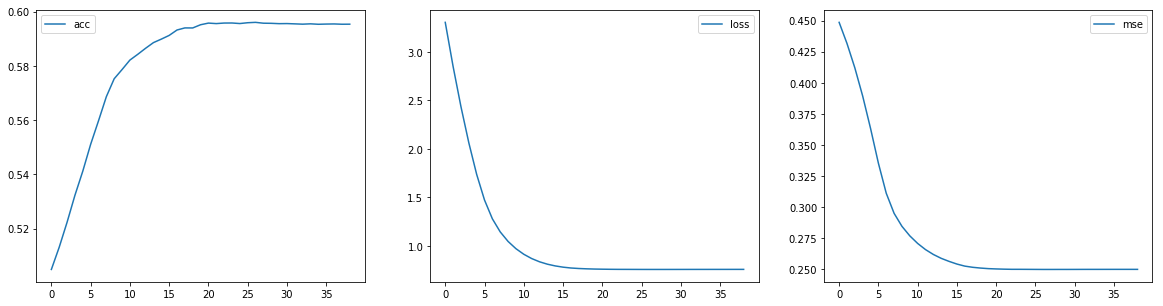

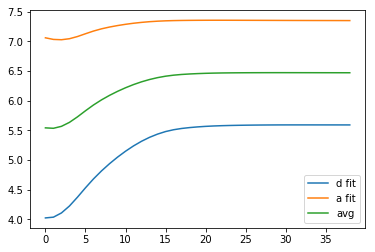

In [143]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [142]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 38.52893714  86.34806414  42.18265211 ...,  36.38065147  22.07869899
    1.67429375]
 [ 65.16567362  43.31820219  46.80575572 ...,  41.83580774   3.43811473
   53.49272155]
 [ 49.67920561  54.17568102  94.44825241 ...,  53.87247539  65.7246675
   23.47225437]
 ..., 
 [ 19.63827616  81.94814511   7.16141095 ...,  55.86671418  47.66744995
    4.50861207]
 [ 85.01964244  30.15164794  94.72837311 ...,  17.65523993  88.99768964
    7.24630063]
 [ 16.49581073  26.76933307  62.42448586 ...,  40.8436665    5.10494581
   57.94986612]]
out [[ 12.6842432   61.04657364  22.41474342 ...,  37.08383942  46.45501709
   16.77356339]
 [ 88.03061676  47.62640762  40.25627136 ...,  35.03888321  69.7223587
   26.44357872]
 [ 33.4242363   86.86795044  63.29909134 ...,  46.66680527  86.97124481
   64.5207901 ]
 ..., 
 [ 88.04650879  86.73287964  41.51177979 ...,  39.34020233  86.39111328
   64.25803375]
 [ 12.75344181  86.76016235  11.0680275  ...,  86.3793869   86.08448029
    4.53388405]
 [ 56.1336

In [139]:
x = []

for _ in range(1):
    xa, _, _, _ = generate_attempts(qs,ss)
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

----0

>>Passed 831229/1600000
model acc: 0.90830875
758021 73498
73208 695273
perplexity is 1.1608704205135054
209454 : 758021 695273 73498 73208


In [140]:
sws = s_table.get_weights()[0]

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sws[psi_id], pred_wgtz[q_id])
    try:
        summa += log((p if passed else (1-p)), base)
    except:
        print("whopps")
        
    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

IndexError: index 160 is out of bounds for axis 0 with size 100

(100, 25) (100, 25)


c:\venvs\isaac64\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


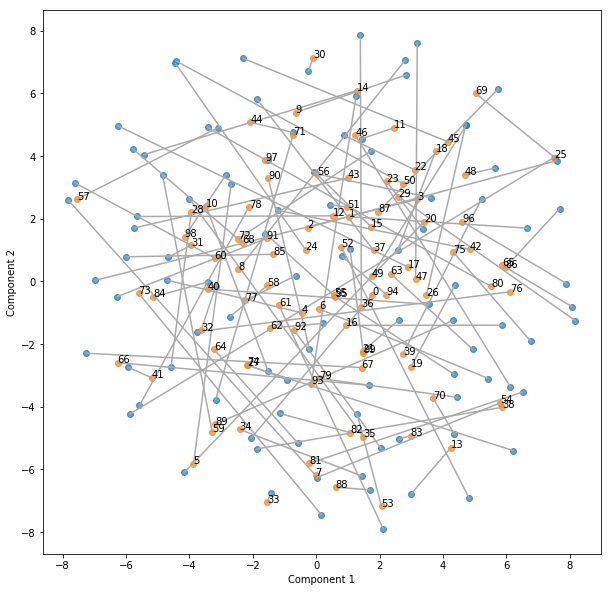

In [95]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()